In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import yaml
from distgen import Generator
from copy import deepcopy

# Dowell-Schmerge Photocathode Model
This notebook demonstrates the use of the Dowell-Schmerge type momentum distribution. Copying from the method's help text:

```
def sample_momentum_dowell_schmerge(...):
    Returns samples from the momentum distribution of a Dowell-Schmerge-like photocathode with
    no scattering effects. Electrons are initially populated in momentum space as in the
    Sommerfeld model. They are then accepted according to the escape condition in [1] with the
    surface normal being (0, 0, 1) in these coordinates. Rejection sampling is performed until
    "samples" samples have been drawn. For the purposes of referencing in published research,
    this is the implementation described in [2].

    [1] Dowell, D. H., & Schmerge, J. F. (2009). Quantum efficiency and thermal emittance of metal 
        photocathodes. Physical Review Special Topics - Accelerators and Beams, 12(7). 
        https://doi.org/10.1103/PhysRevSTAB.12.074201

    [2] Pierce, C. M., Durham, D. B., Riminucci, F., Dhuey, S., Bazarov, I., Maxson, J., Minor, 
        A. M., & Filippetto, D. (2023). Experimental Characterization of Photoemission from 
        Plasmonic Nanogroove Arrays. Physical Review Applied, 19(3), 034034.
        https://doi.org/10.1103/PhysRevApplied.19.034034
```

In [2]:
# Create an example input configuration
input_yaml = """
n_particle: 100000
start: 
  type: free
random:
  type: hammersley
total_charge:
  units: pC
  value: 10
r_dist:
  max_r:
    units: mm
    value: 1
  type: radial_uniform
dowell_schmerge_dist:
  photon_energy:
    units: eV
    value: 2.5
  workfun:
    units: eV
    value: 2.0
  fermi_energy:
    units: eV
    value: 5.5
"""

# Create the particle distribution
gen = Generator(input_yaml, verbose=True)
P = gen.run()

Distribution format: None
Output file: None

Creating beam distribution....
   Beam starting from: free
   Total charge: 10 pC.
   Number of macroparticles: 100000.
   Assuming cylindrical symmetry...
   r distribution: radial uniform
      min_r = 0 mm, max_r = 1 mm
   theta distribution: uniform theta
      min_theta = 0 rad, max_theta = 6.28319 rad
   p distribution: Dowell-Schmerge photocathode model:    Shifting avg_x = -2.11128E-05 mm -> 0 mm
   Scaling sigma_x = 0.499982 mm -> 0.5 mm
   Shifting avg_y = -1.96891E-06 mm -> 0 mm
   Scaling sigma_y = 0.499998 mm -> 0.5 mm
   Shifting avg_px = 0.15908 eV/c -> 0 eV/c
   Shifting avg_py = -0.5161 eV/c -> 0 eV/c
...done. Time Elapsed: 5.69731 s.

   Created particles in .particles: 
   ParticleGroup with 100000 particles with total charge 1.0000000000000003e-11 C


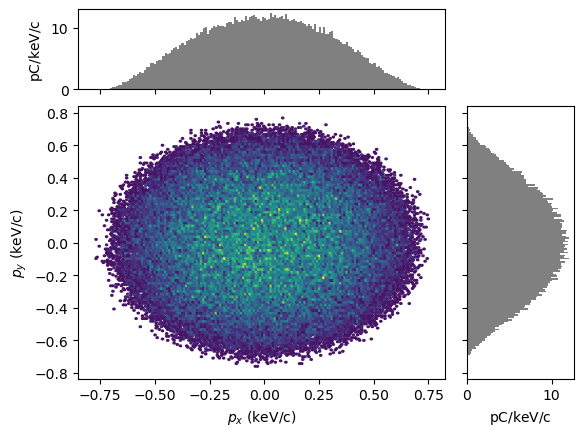

In [3]:
# Plot the transverse momentum
P.plot('px', 'py')

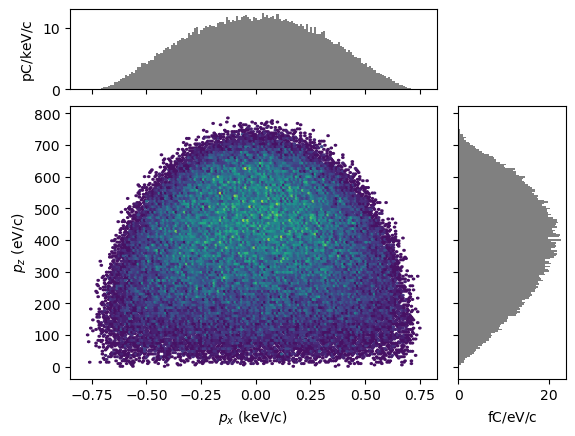

In [4]:
# Plot the longitudinal momentum
P.plot('px', 'pz')

## Demonstration of MTE Modeling
The Dowell-Schmerge calculation gives the mean transverse energy (MTE) of the photocathode as $(h\nu - \phi)/3$ where $h\nu$ is the photon energy and $\phi$ is the workfunction. With the addition of a cathode temperature which affects the occupation function, the MTE will be modified near threshold and no longer go all the way to zero. We demonstrate this with the sampling implemented in distgen.

Text(0, 0.5, 'MTE (meV)')

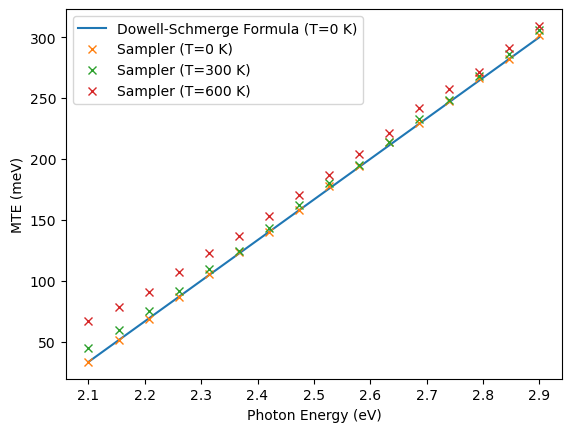

In [5]:
# Give this plot a few minutes to generate as many distributions are being generated and measured
def get_mte(base_conf, photon_energy, temp, n=int(3e4)):
    # Change the settings
    my_conf = deepcopy(base_conf)
    my_conf['n_particle'] = n
    my_conf['dowell_schmerge_dist']['photon_energy']['value'] = float(photon_energy)
    my_conf['dowell_schmerge_dist']['temp'] = float(temp)

    # Run distgen
    gen = Generator(yaml.dump(my_conf))
    P = gen.run()

    # Calculate MTE
    return P.std('px')**2/mc2*1e3

np.random.seed(0)
mc2 = 511e3
ephoton = np.linspace(2.1, 2.9, 16)
plt.plot(ephoton, (ephoton-2)/3*1e3, label='Dowell-Schmerge Formula (T=0 K)')

for temp in [0, 300, 600]:
    mte = np.array([get_mte(yaml.safe_load(input_yaml), ep, temp) for ep in ephoton])
    plt.plot(ephoton, mte, marker='x', ls='none', label='Sampler (T=%.0f K)' % temp)
plt.legend()
plt.xlabel('Photon Energy (eV)')
plt.ylabel('MTE (meV)')